# Recreating the NN in this paper
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

import random

# Reading file

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

# Vocabulary mapping

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Creating a single dataset

In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

# Creating Train, Test, Dev dataset

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [8]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#  Creating Embedding table

**Instead of doing a multiplication with `One hot encoding` and the embedding matrix, here `C`, it's easier to index into `C` directly as it's one and the same.**

Now for pytorch the indexing is really cool. Look at the following examples:
```python
C[0]
C[[0,0,0]]
C[torch.tensor((0,0,0))]
C[torch.randint(0,1,(2,2))]
```

In [9]:
C = torch.randn((27, 2))

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
emb[0]

tensor([[-1.2415, -0.1278],
        [-1.2415, -0.1278],
        [-1.2415, -0.1278]])

# Creating the first NN layer

**The first layer takes in the 3 embeddings and feeds into a tanh layer. Since there are 3 embeddings each of size 2 the total no. of inputs is 3*2=6, with the number of neurons that we would want, in this case 100. So the final Weight matrix =(6,100)**

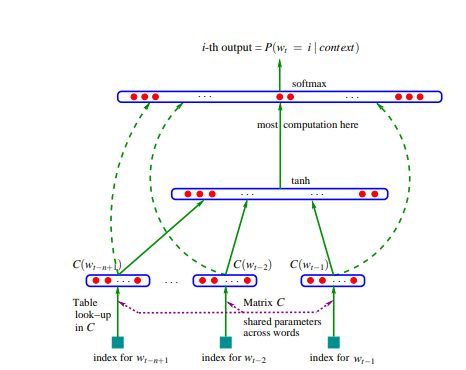

In [12]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

After initialising the weight matrix and the bias vector, the 3 embedding matrices have to be concatenated first, as in the diagram above, and then multiplied together with the weight matrix. Concatenating the 3 embedding matrices will return a matrix of shape (n,6) as initially each embedding matrix had a shape of (27,2). To represent a single character we would need a matrix of shape(1,2) and since there are three characters chosen so they will need to be represented by (3,2), concatenating these three character embeddings would return a matrix of shape (1,6). Therefore, to represent n such blocks of 3 characters each we will need a (n,6) concatenated matrix.

There are many ways to concatenate the embedding matrices and below are some of the options.

1. Concatenate into a single embedding matrix, in our case as there are 3 embedding matrices, so there will be 3 separate embedding matrices to be concatenated. If there are n embedding matrices then n embedding matrices need to be concatenated. The following code isn't scalable to n embedding matrices of course.
```python
# selecting the 3 embedding matrices separately
emb[:,0,:], emb[:,1,:], emb[:,2,:]# will return each of shape (n,2) as each embedding matrix has (n,2) dimension
# concatenating each (n,2) matrix along dimension 1 will give us a (n,6) matrix
# as each row of each matrix will be concatenated into a single row thus giving us (n,3*2) numbers in each row
# if the concatenation is done with dimension 0, then it will concatenate each row instead of the columns returning (3*n,2)
torch.cat((emb[:,0,:], emb[:,1,:], emb[:,2,:]),dim=1)
```
2. The above example isn't scalable as each matrix needs to be separated out first and as the dimensions of the embedding matrix increases separating them out in the manner above is unfeasible, however the same can be done with another method from torch:
```python
# this will give us a tuple of 3 matrices each the shape of (n,2) because the embedding matrix has a shape of (n,3,2) and torch.unbind along dimension 1 will separate the matrix into 3 matrices of (n,2) effectively a tuple of matrices ((n,2),(n,2),(n,2))
torch.unbind(emb, dim=1)
# now the same concat will work to give us the a single concatenated matrix (n,6)
torch.cat(torch.unbind(emb,dim=1), dim=1)
```
3. The above two operations are very memory intensive as they create new matrices and store it in memory. However, the best way to perform this is to reshape the matrix:
```python
# the 3 embedding matrices need to be concatenated into a single matrix with dimension (n,6)
# and just by reshaping the embedding matrix one can achieve the same; since the final matrix
# dimension is (n,6), the embedding matrix can be reshaped simply as (n,6) and it will turn
# out that it's the same as concatenating the 3 embedding matrices 
emb.view(emb.shape[0], 6)
# or 
emb.view(-1, 6)
```
For verification that all the 3 results produce the same concatenated embedding matrix, execute the following:
```python
torch.cat((emb[:,0,:], emb[:,1,:], emb[:,2,:]),dim=1)[0], torch.cat(torch.unbind(emb,dim=1), dim=1)[0], emb.view(emb.shape[0], 6)[0]
```

Now that we have concatenated the 3 embedding matrices we can multiply them with the weight matrix and add the bias to it. 
We will also need to pass the outputs through `tanh` non-linearity.

In [77]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# or 
# h = (emb.view(-1, 6) @ W1 + b1).tanh

In [79]:
h.shape

torch.Size([228146, 100])

Now for the final layer of the NN, `we need to output 27 logits`, one for each character, and the `input has to be 100 as the previous layer returned (n,100)`, so we choose `(100,27)` as the weight matrix and add a bias vector of 27 to it.

In [80]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [81]:
logits = h @ W2 + b2

In [82]:
logits.shape

torch.Size([228146, 27])

The following two cells is for `Softmax` and it could be done in a single operation `F.softmax(logits, dim=1)`.
The variable `prob` and `F.softmax(logits, dim=1)` are identical but if you compare it element wise you will notice that some of them return false due to floating point precision errors but actually visually compared they are identical and for all purposes these two operations yield identical results.

In [83]:
counts = logits.exp()

In [84]:
prob = counts / counts.sum(1, keepdims=True)

In [85]:
prob.shape

torch.Size([228146, 27])

Calculating the NLL of the entire dataset.

In [121]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(15.7856)

# Generalising the NN implementation
Increasing the embedding matrix to 10 and adding more neurons to the hidden layers

In [129]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [130]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [135]:
# identical as above
sum(p.numel() for p in parameters) # number of parameters in total

11897

Marking the parameters grad=True

In [131]:
for p in parameters:
  p.requires_grad = True

Initialising the learning rate

In [136]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [154]:
lri = []
lossi = []
stepi = []

Running the entire training of the NN

In [155]:
for i in range(200_000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    # this is the same as calculating the softmax and computing the NLL loss
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass; initially resetting the gradients
    # and then backpropagating
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update the gradients
    # learning rate decay, before 100K the learning rate is higher
    # and after that it's lower
    #lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    #print(loss.item())

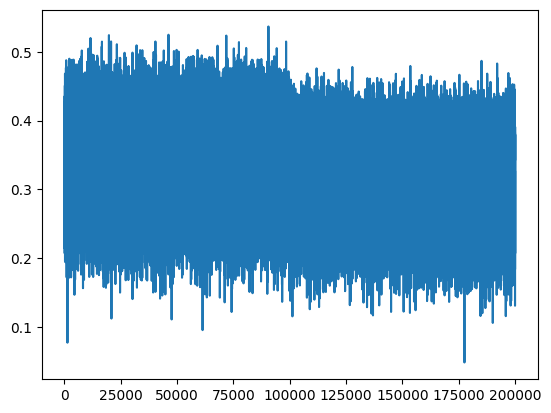

In [156]:
plt.plot(stepi, lossi)

Calculating the training loss

In [157]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0588, grad_fn=<NllLossBackward0>)

Calculating the development loss

In [158]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1317, grad_fn=<NllLossBackward0>)

Visualize dimensions 0 and 1 of the embedding matrix C for all characters

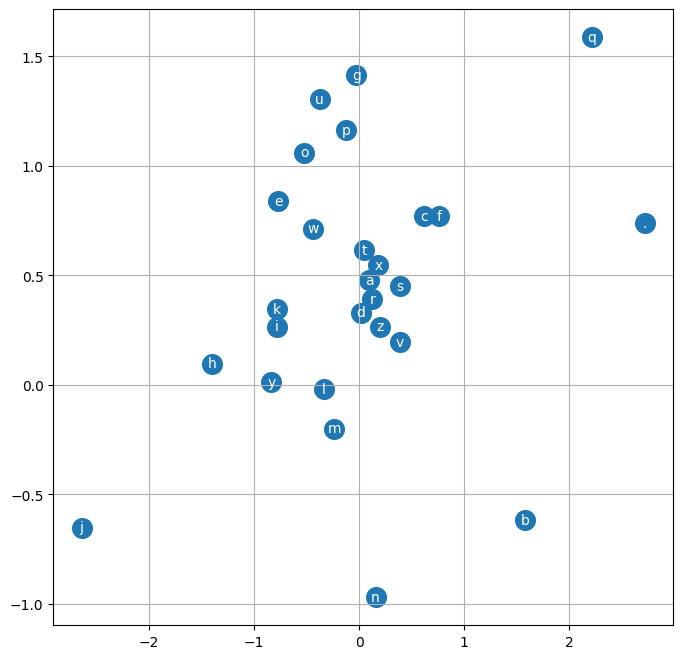

In [148]:

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Generating sample names or inferencing

In [150]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seen.
nihahalerethrs.
endraegrazeer.
selin.
shi.
jenue.
elieananara.
pyrion.
kamin.
shubergiairiel.
kinleenellennie.
cayub.
kaveer.
yarul.
els.
kayshaston.
azhya.
salynn.
